# Conformal Prediction for Regression

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Dat Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError

# SciPy
from scipy.stats import rankdata

#
import openml

# Notebook Opt
from tqdm import tqdm

# Crepes
from crepes import WrapRegressor
from crepes.extras import binning
from crepes.extras import DifficultyEstimator

# Mapie
from mapie.subsample import Subsample
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score

# Scikit-Learn

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestRegressor
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix

# Boosting Libraries
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Conformal Libraries
from nonconformist.nc import NcFactory
from nonconformist.cp import IcpClassifier
from nonconformist.cp import TcpClassifier
from nonconformist.base import ClassifierAdapter
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc, ClassifierNc

### Mandatory Libraries

```sh
!pip install dtype_diet
!pip install openml
!pip install mapie
!pip install crepes
!pip install aws-fortuna
```

In [2]:
%matplotlib inline

In [3]:
random_state = 23
rng = np.random.default_rng(random_state)
round_to = 3

#### Loading Data: `https://docs.openml.org/Python-API/`

In [4]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [5]:
datasets_df.head()

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0


#### California Data Information

In [6]:
datasets_df.loc[43939]

name                                  california_housing
version                                                1
uploader                                           30861
status                                            active
format                                              ARFF
MajorityClassSize                                    NaN
MaxNominalAttDistinctValues                          NaN
MinorityClassSize                                    NaN
NumberOfClasses                                      0.0
NumberOfFeatures                                    10.0
NumberOfInstances                                20640.0
NumberOfInstancesWithMissingValues                 207.0
NumberOfMissingValues                              207.0
NumberOfNumericFeatures                              9.0
NumberOfSymbolicFeatures                             1.0
Name: 43939, dtype: object

In [7]:
dataset = openml.datasets.get_dataset(43939)

# Retrieving Summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'california_housing', the target feature is 'median_house_value'
URL: https://api.openml.org/data/v1/download/22102987/california_housing.arff
Median house prices for California districts derived from the 1990 census.


In [8]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

df = pd.DataFrame(X, columns=attribute_names)

df["class"] = y

#### Checking for Categorical Variables

In [9]:
categorical_indicator

[False, False, False, False, False, False, False, False, True]

In [10]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,class
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,3.0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0,342200.0


In [11]:
df['ocean_proximity'].unique()

array([3., 0., 1., 4., 2.], dtype=float32)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20433 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   ocean_proximity     20640 non-null  float32
 9   class               20640 non-null  float64
dtypes: float32(9), float64(1)
memory usage: 887.0 KB


In [13]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

In [14]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
class                   0
dtype: int64

In [15]:
df.dropna(subset=['total_bedrooms'], inplace=True)

In [16]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [17]:
# Features
X = df.drop('class', axis = 1)

# Target
y = df['class']

### Inductive Conformal Prediction

For ICP is required:

1. Splitting The Datasets into 3 Datasets: A `Traininig set`, A `Calibration` & `Test Set`

2. The Training Set is used to train the underlying model, The Calibration Set is used by Conformal Prediction & Test Set is used to Test models

In [18]:
# Splitting Procedure
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

In [19]:
# A 1000 Objects for Calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

In [20]:
# Checking Splitting Shape:
print('Data split. Parts sizes: train = {}, calib = {}, test = {}'.format(X_proper_train.shape, X_cal.shape, X_test.shape))

Data split. Parts sizes: train = (19333, 9), calib = (1000, 9), test = (100, 9)


### `Note`: 
#### The Author provides literature resources for a broader scope on `CP-ICP`. Check author's book and original repository.

### Conformal Prediction procedure: `To Explain`

### Naive Inductive Conformal Prediction Regression steps: `To Provide`

In [21]:
# Setting Model
model = RandomForestRegressor(n_jobs=-1)

# Fitting Model
model.fit(X_proper_train, y_proper_train)

RandomForestRegressor(n_jobs=-1)

In [22]:
alpha = 0.05

n_cal = len(y_cal)

n_cal

1000

In [24]:
# Point Predictions on The Calibration & Test Sets
y_pred_cal = model.predict(X_cal)

y_pred_test = model.predict(X_test)

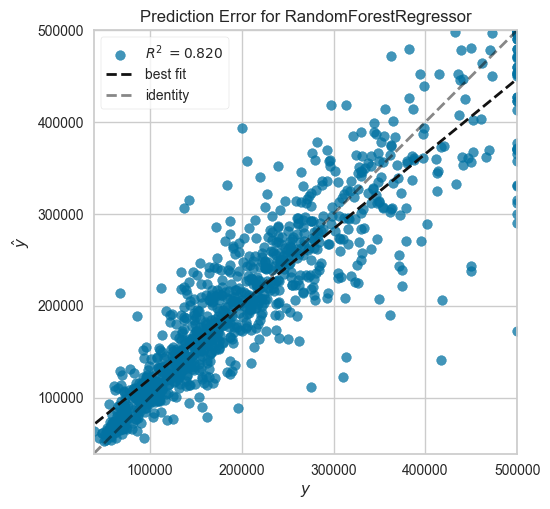

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [25]:
# Modelling Prediction Error
visualizer = PredictionError(model)

# Placing on Test set
visualizer.score(X_cal, y_cal)
visualizer.show()                 

In [26]:
# Calibration Errors
y_cal_error = np.abs(y_cal - y_pred_cal)

In [27]:
# Quantile Calculation with Coverage Final Sample Adjustment
np.ceil((n_cal+1)*(1-alpha))/n_cal

0.951

#### # `q_hat` on Calibration Set

In [28]:
q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)

q_yhat_cal

102118.12086

### Calibration Error

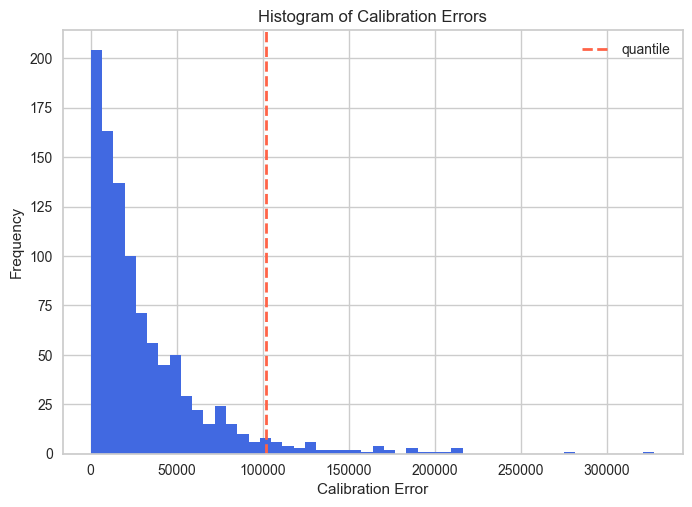

In [30]:
plt.hist(y_cal_error, bins='auto', color='royalblue')

plt.axvline(q_yhat_cal, color='tomato', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Calibration Error')
plt.ylabel('Frequency')
plt.title('Histogram of Calibration Errors')

plt.show()